# LFW Dataset Preparation for Face Matching

Preparation of the LFW (Labeled Faces in the Wild) dataset for training and evaluating face matching models.

## Objectives

1. Download LFW dataset using kagglehub
2. Process matchpairsDevTest.csv file
3. Normalize data and create labels
4. Split dataset into 60% train, 10% val, 30% test
5. Save as CSV files for use with PyTorch Dataset

In [ ]:
# Install required packages
!pip install kagglehub pandas scikit-learn numpy

In [1]:
# Import libraries
import kagglehub
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

print("Libraries imported successfully!")

/home/uyennhi/miniconda3/envs/facematching/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!


In [2]:
# Download LFW dataset from Kaggle
print("Downloading LFW dataset from Kaggle...")
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print(f"Dataset downloaded to: {path}")

Dataset downloaded to: /home/uyennhi/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4


In [3]:
# Read matchpairsDevTest.csv file
csv_file = os.path.join(path, "matchpairsDevTest.csv")
df = pd.read_csv(csv_file)
print(f"Read CSV file with {len(df)} rows")

# Add match column and create full image paths
df['match'] = 1  # Same person pairs
df['image1'] = df.apply(lambda row: f"lfw/{row['name']}/{row['name']}_{row['imagenum1']:04d}.jpg", axis=1)
df['image2'] = df.apply(lambda row: f"lfw/{row['name']}/{row['name']}_{row['imagenum2']:04d}.jpg", axis=1)

print("Data after processing:")
print(df.head())

Read CSV file with 500 rows
Data after processing:
               name  imagenum1  imagenum2  match  \
0      Abdullah_Gul         13         14      1   
1      Abdullah_Gul         13         16      1   
2  Abdullatif_Sener          1          2      1   
3    Adel_Al-Jubeir          1          3      1   
4         Al_Pacino          1          2      1   

                                           image1  \
0          lfw/Abdullah_Gul/Abdullah_Gul_0013.jpg   
1          lfw/Abdullah_Gul/Abdullah_Gul_0013.jpg   
2  lfw/Abdullatif_Sener/Abdullatif_Sener_0001.jpg   
3      lfw/Adel_Al-Jubeir/Adel_Al-Jubeir_0001.jpg   
4                lfw/Al_Pacino/Al_Pacino_0001.jpg   

                                           image2  
0          lfw/Abdullah_Gul/Abdullah_Gul_0014.jpg  
1          lfw/Abdullah_Gul/Abdullah_Gul_0016.jpg  
2  lfw/Abdullatif_Sener/Abdullatif_Sener_0002.jpg  
3      lfw/Adel_Al-Jubeir/Adel_Al-Jubeir_0003.jpg  
4                lfw/Al_Pacino/Al_Pacino_0002.jpg  


In [4]:
# Normalize data and create labels
processed_data = []

for _, row in df.iterrows():
    # Keep original paths and add label
    processed_data.append({
        'image1': row['image1'],
        'image2': row['image2'],
        'label': 1  # Same person (match=1)
    })

# Create DataFrame
df_processed = pd.DataFrame(processed_data)

print(f"Processed {len(df_processed)} image pairs")
print("Normalized data sample:")
print(df_processed.head())

Processed 500 image pairs
Normalized data sample:
                                           image1  \
0          lfw/Abdullah_Gul/Abdullah_Gul_0013.jpg   
1          lfw/Abdullah_Gul/Abdullah_Gul_0013.jpg   
2  lfw/Abdullatif_Sener/Abdullatif_Sener_0001.jpg   
3      lfw/Adel_Al-Jubeir/Adel_Al-Jubeir_0001.jpg   
4                lfw/Al_Pacino/Al_Pacino_0001.jpg   

                                           image2  label  
0          lfw/Abdullah_Gul/Abdullah_Gul_0014.jpg      1  
1          lfw/Abdullah_Gul/Abdullah_Gul_0016.jpg      1  
2  lfw/Abdullatif_Sener/Abdullatif_Sener_0002.jpg      1  
3      lfw/Adel_Al-Jubeir/Adel_Al-Jubeir_0003.jpg      1  
4                lfw/Al_Pacino/Al_Pacino_0002.jpg      1  


In [5]:
# Read mismatchpairsDevTrain.csv to create negative pairs (label = 0)
print("Adding negative pairs (different people)")

mismatch_file = os.path.join(path, "mismatchpairsDevTrain.csv")
mismatch_df = pd.read_csv(mismatch_file)
print(f"Read {len(mismatch_df)} mismatch pairs")

# Create negative pairs
negative_data = []
for _, row in mismatch_df.iterrows():
    # Create paths for two different people's images
    name1 = row['name']
    name2 = row['name.1']
    imagenum1 = row['imagenum1']
    imagenum2 = row['imagenum2']

    image1_path = f"lfw/{name1}/{name1}_{imagenum1:04d}.jpg"
    image2_path = f"lfw/{name2}/{name2}_{imagenum2:04d}.jpg"

    negative_data.append({
        'image1': image1_path,
        'image2': image2_path,
        'label': 0  # Different people
    })

# Create DataFrame for negative pairs
negative_df = pd.DataFrame(negative_data)

# Combine positive and negative pairs
all_pairs_df = pd.concat([df_processed, negative_df], ignore_index=True)
all_pairs_df = all_pairs_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total: {len(all_pairs_df)} image pairs")
print(f"Label distribution: {all_pairs_df['label'].value_counts().to_dict()}")

# Update processed DataFrame
df_processed = all_pairs_df

Adding negative pairs (different people)
Read 1100 mismatch pairs
Total: 1600 image pairs
Label distribution: {0: 1100, 1: 500}


In [6]:
# Split dataset: 60% train, 10% val, 30% test
print("Splitting dataset...")

# First split into train (60%) and temp (40%)
X = df_processed[['image1', 'image2']]
y = df_processed['label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Split temp into val (10%) and test (30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.75, random_state=42, stratify=y_temp
)

# Create DataFrames for each set
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(f"Train set: {len(train_df)} samples ({len(train_df)/len(df_processed)*100:.1f}%)")
print(f"Validation set: {len(val_df)} samples ({len(val_df)/len(df_processed)*100:.1f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(df_processed)*100:.1f}%)")

Splitting dataset...
Train set: 960 samples (60.0%)
Validation set: 160 samples (10.0%)
Test set: 480 samples (30.0%)


In [7]:
# Save CSV files with format: image1,image2,label
print("Saving CSV files...")

# Create output directory if it doesn't exist
output_dir = "lfw_face_matching_dataset"
os.makedirs(output_dir, exist_ok=True)

# Save CSV files
train_file = os.path.join(output_dir, "train.csv")
val_file = os.path.join(output_dir, "val.csv")
test_file = os.path.join(output_dir, "test.csv")

train_df.to_csv(train_file, index=False)
val_df.to_csv(val_file, index=False)
test_df.to_csv(test_file, index=False)

print(f"Files saved successfully:")
print(f"- {train_file} ({len(train_df)} samples)")
print(f"- {val_file} ({len(val_df)} samples)")
print(f"- {test_file} ({len(test_df)} samples)")

Saving CSV files...
Files saved successfully:
- lfw_face_matching_dataset/train.csv (960 samples)
- lfw_face_matching_dataset/val.csv (160 samples)
- lfw_face_matching_dataset/test.csv (480 samples)


## Summary

The LFW dataset has been prepared for face matching:

1. Downloaded LFW dataset from Kaggle
2. Created positive pairs (same person) and negative pairs (different people)
3. Split into train/val/test sets with proper stratification
4. Saved as CSV files in the `lfw_face_matching_dataset` directory

Files are ready to use with PyTorch Dataset for training face matching models.

# Evaluation with VGGFace2

Evaluating the face matching performance using pre-trained VGGFace2 model.

In [8]:
# Install and import libraries for evaluation
!pip install facenet-pytorch scikit-learn matplotlib seaborn

import torch
from torch.utils.data import Dataset, DataLoader
from facenet_pytorch import InceptionResnetV1
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load VGGFace2 pre-trained model
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
print("VGGFace2 model loaded successfully")

  Using cached torch-2.2.2-cp312-cp312-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached torchvision-0.17.2-cp312-cp312-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.met

In [9]:
# Create Dataset class for face matching
class FaceMatchingDataset(Dataset):
    def __init__(self, csv_file, dataset_path, transform=None):
        self.data = pd.read_csv(csv_file)
        self.dataset_path = dataset_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Full paths to images - replace 'lfw/' with 'lfw-deepfunneled/'
        img1_relative = row['image1'].replace('lfw/', 'lfw-deepfunneled/')
        img2_relative = row['image2'].replace('lfw/', 'lfw-deepfunneled/')

        img1_path = os.path.join(self.dataset_path, img1_relative)
        img2_path = os.path.join(self.dataset_path, img2_relative)

        # Load images
        image1 = Image.open(img1_path).convert('RGB')
        image2 = Image.open(img2_path).convert('RGB')

        # Transform
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        label = int(row['label'])

        return {
            'image1': image1,
            'image2': image2,
            'label': label,
            'img1_path': row['image1'],
            'img2_path': row['image2']
        }

# Define transform function
def transform_image(image):
    # Resize to 160x160
    image = image.resize((160, 160))

    # Convert to numpy array and normalize
    img_array = np.array(image, dtype=np.float32) / 255.0

    # Convert to tensor with correct dimensions
    img_tensor = torch.from_numpy(img_array).permute(2, 0, 1)

    # Normalize to [-1, 1] for VGGFace2
    img_tensor = (img_tensor - 0.5) / 0.5

    return img_tensor

# Define dataset path
dataset_path = "/home/uyennhi/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled"

In [10]:
# Load test dataset
test_csv = "lfw_face_matching_dataset/test.csv"
print(f"Loading test dataset from: {test_csv}")

test_dataset = FaceMatchingDataset(
    csv_file=test_csv,
    dataset_path=dataset_path,
    transform=transform_image
)

# Create DataLoader
batch_size = 32
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2 if device.type == 'cuda' else 0
)

print(f"Test dataset: {len(test_dataset)} samples")
print(f"Test DataLoader: {len(test_loader)} batches (batch_size={batch_size})")

Loading test dataset from: lfw_face_matching_dataset/test.csv
Test dataset: 480 samples
Test DataLoader: 15 batches (batch_size=32)


In [11]:
# Evaluate model on test set
print("Starting evaluation on test set")

model.eval()
similarity_scores = []
true_labels = []

print(f"Processing {len(test_loader)} batches...")

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        if batch_idx % 10 == 0:
            print(f"Processing batch {batch_idx+1}/{len(test_loader)}...")

        images1 = batch['image1'].to(device)
        images2 = batch['image2'].to(device)
        labels = batch['label']

        # Extract embeddings
        embeddings1 = model(images1)
        embeddings2 = model(images2)

        # Calculate similarity for each pair in batch
        for i in range(len(embeddings1)):
            emb1 = embeddings1[i].cpu().numpy()
            emb2 = embeddings2[i].cpu().numpy()

            # Calculate cosine similarity
            similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

            similarity_scores.append(similarity)
            true_labels.append(labels[i].item())

print(f"Processed {len(similarity_scores)} test samples")
print(f"Similarity range: [{min(similarity_scores):.4f}, {max(similarity_scores):.4f}]")

Starting evaluation on test set
Processing 15 batches...
Processing batch 1/15...
Processing batch 11/15...
Processed 480 test samples
Similarity range: [-0.3440, 0.9490]


In [12]:
# Find optimal threshold based on F1-score
print("Finding optimal threshold")

thresholds = np.arange(0.0, 1.0, 0.01)
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    predictions = [1 if score >= threshold else 0 for score in similarity_scores]
    f1 = f1_score(true_labels, predictions, zero_division=0)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Calculate metrics with optimal threshold
final_predictions = [1 if score >= best_threshold else 0 for score in similarity_scores]

accuracy = accuracy_score(true_labels, final_predictions)
precision = precision_score(true_labels, final_predictions)
recall = recall_score(true_labels, final_predictions)
f1 = f1_score(true_labels, final_predictions)

print(f"Best threshold: {best_threshold:.3f}")
print(f"Metrics with optimal threshold:")
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-score:  {f1:.4f} ({f1*100:.2f}%)")

Finding optimal threshold
Best threshold: 0.390
Metrics with optimal threshold:
Accuracy:  0.9792 (97.92%)
Precision: 0.9605 (96.05%)
Recall:    0.9733 (97.33%)
F1-score:  0.9669 (96.69%)


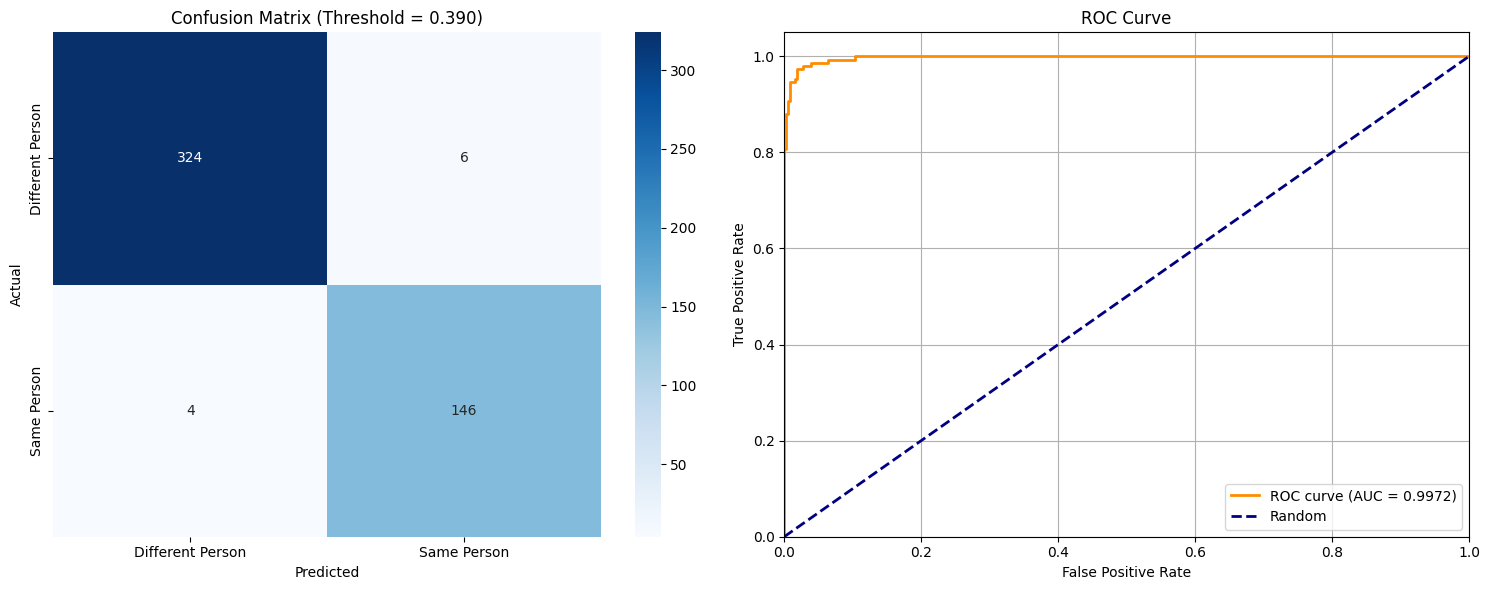

Classification Report:
                  precision    recall  f1-score   support

Different Person       0.99      0.98      0.98       330
     Same Person       0.96      0.97      0.97       150

        accuracy                           0.98       480
       macro avg       0.97      0.98      0.98       480
    weighted avg       0.98      0.98      0.98       480



In [13]:
# Plot Confusion Matrix and ROC Curve

# Confusion Matrix
cm = confusion_matrix(true_labels, final_predictions)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Different Person', 'Same Person'],
            yticklabels=['Different Person', 'Same Person'])
axes[0].set_title(f'Confusion Matrix (Threshold = {best_threshold:.3f})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, similarity_scores)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, final_predictions,
                          target_names=['Different Person', 'Same Person']))

In [14]:
# Results summary
print("Evaluation Results Summary")

print(f"Dataset Test:")
print(f"- Total samples: {len(true_labels)}")
print(f"- Same person pairs: {sum(true_labels)} ({sum(true_labels)/len(true_labels)*100:.1f}%)")
print(f"- Different person pairs: {len(true_labels)-sum(true_labels)} ({(len(true_labels)-sum(true_labels))/len(true_labels)*100:.1f}%)")

print(f"\nModel: VGGFace2 (InceptionResnetV1)")
print(f"- Optimal threshold: {best_threshold:.4f}")

print(f"\nPerformance Metrics:")
print(f"- Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"- Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"- Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"- F1-score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"- AUC:       {roc_auc:.4f} ({roc_auc*100:.2f}%)")

Evaluation Results Summary
Dataset Test:
- Total samples: 480
- Same person pairs: 150 (31.2%)
- Different person pairs: 330 (68.8%)

Model: VGGFace2 (InceptionResnetV1)
- Optimal threshold: 0.3900

Performance Metrics:
- Accuracy:  0.9792 (97.92%)
- Precision: 0.9605 (96.05%)
- Recall:    0.9733 (97.33%)
- F1-score:  0.9669 (96.69%)
- AUC:       0.9972 (99.72%)
